### Import libraries

In [1]:
%%capture
#!pip install scanpy
#!pip install KDEpy
#!pip install leidenalg

In [2]:
%%capture
# Remember to restart the kernel once installed
#!pip install -e ../../../tools/nomad/

In [1]:
import os
import sys

import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import scipy.sparse as sps
from scipy.stats import spearmanr, kendalltau, pearsonr

# to be able to import from tools dir
module_path = os.path.abspath(os.path.join("../"))
if module_path not in sys.path:
    sys.path.append(module_path)

import tools.util as ut
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co

import fi_nomad as nmd
from fi_nomad.types import kernelInputTypes
from fi_nomad.types import KernelStrategy
from fi_nomad.types import InitializationStrategy

import warnings

warnings.filterwarnings("ignore")

import importlib
import logging

In [2]:
# logging has to manually turned on to see nomad output
logging.basicConfig(level=logging.INFO)

### Read data

In [4]:
data_path = "../data/S2"
figure_path = f"{data_path}/figures/raw_counts"
layer = "counts"

In [4]:
data = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed_and_pca.h5ad")
data

AnnData object with n_obs × n_vars = 1255 × 5540
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt_PCA'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std'
    uns: 'BacSC_params_PCA', 'PCA', 'leiden', 'leiden_opt_PCA_colors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
    obsp: 'PCA_connectivities', 'PCA_distances'

### Countsplit

In [5]:
data_train, data_test = cs.countsplit_adata(
    data,
    data_dist="NB",
    beta_key="nb_overdisp_cutoff",
    layer=layer,
    min_genes=1,
    max_counts=1e9,
    seed=1234,
)

### Search latent dimension and momentum parameter

In [6]:
ks_2_check = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
betas_2_check = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
betas_2_check

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In case you don't want to rerun:

In [12]:
k_opt = 1
beta_opt = 0.7

In [8]:
select_cs_results = cs.select_3b_params_countsplit(
    data_train,
    data_test,
    potential_ks=ks_2_check,
    potential_betas=betas_2_check,
    layer=layer,
    maxiters=200,
)

################## LATENT DIM 10


INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.0


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 5.474798672366887e-05 loop took 38.23818145300902 overall (0.1911909072650451/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.0258001061156392e-05 loop took 38.40415936300997 overall (0.19202079681504983/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.4327004211954772e-05 loop took 36.81054960600159 overall (0.18405274803000793/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.2599997464567423e-05 loop took 37.025401523002074 overall (0.18512700761501036/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.6281999200582504e-05 loop took 37.24314107099781 overall (0.18621570535498905/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5519999326206744e-05 loop took 36.34164484399662 overall (0.1817082242199831/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.2837994038127363e-05 loop took 35.477160380003625 overall (0.17738580190001813/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.259199391119182e-05 loop took 33.48324281499663 overall (0.16741621407498314/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.3410000721924007e-05 loop took 33.42027655900165 overall (0.16710138279500825/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.4203996872529387e-05 loop took 34.214490041005774 overall (0.17107245020502887/ea)


################## LATENT DIM 9


INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.0


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.4405995393171906e-05 loop took 33.837572976000956 overall (0.16918786488000478/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.2127991542220116e-05 loop took 33.877408940010355 overall (0.16938704470005178/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5713001377880573e-05 loop took 34.05011435499182 overall (0.1702505717749591/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5604997063055634e-05 loop took 33.8911109840119 overall (0.1694555549200595/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.536899410188198e-05 loop took 33.84194929500518 overall (0.1692097464750259/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.4120992748066783e-05 loop took 33.90837355000258 overall (0.1695418677500129/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.3842992959544063e-05 loop took 33.86186054699647 overall (0.16930930273498235/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.862099790945649e-05 loop took 34.23675131499476 overall (0.1711837565749738/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.778299676720053e-05 loop took 38.971479507003096 overall (0.1948573975350155/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.4679000489413738e-05 loop took 37.51458833900688 overall (0.18757294169503438/ea)


################## LATENT DIM 8


INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.0


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.7228004657663405e-05 loop took 35.897345293997205 overall (0.17948672646998604/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.4362001568078995e-05 loop took 33.34477316099219 overall (0.16672386580496096/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.3508997401222587e-05 loop took 33.3232899440045 overall (0.1666164497200225/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5352986995130777e-05 loop took 33.37935551600822 overall (0.1668967775800411/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.4654000299051404e-05 loop took 33.24037922000571 overall (0.16620189610002853/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.3540997062809765e-05 loop took 33.3157468099962 overall (0.166578734049981/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.3549990146420896e-05 loop took 33.46404576599889 overall (0.16732022882999445/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.4406996089965105e-05 loop took 33.365965488992515 overall (0.16682982744496258/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5483997887931764e-05 loop took 33.371906376007246 overall (0.16685953188003622/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.4976005079224706e-05 loop took 34.673076124992804 overall (0.173365380624964/ea)


################## LATENT DIM 7


INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.0


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.7743008104152977e-05 loop took 32.743683594002505 overall (0.16371841797001252/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.2306005121208727e-05 loop took 32.73824479599716 overall (0.1636912239799858/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.4859007680788636e-05 loop took 32.94307528299396 overall (0.1647153764149698/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.8974012820981443e-05 loop took 32.9344817569945 overall (0.1646724087849725/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.541499270591885e-05 loop took 34.816396659007296 overall (0.1740819832950365/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.2662003175355494e-05 loop took 33.30341159799718 overall (0.16651705798998592/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.2545005776919425e-05 loop took 34.631209314000444 overall (0.17315604657000222/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.547199255786836e-05 loop took 33.994038916003774 overall (0.16997019458001886/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.3917993530631065e-05 loop took 33.64215975200932 overall (0.1682107987600466/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.4819004465825856e-05 loop took 33.9629068679933 overall (0.1698145343399665/ea)


################## LATENT DIM 6


INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.0


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 7.777300197631121e-05 loop took 32.32816276099766 overall (0.1616408138049883/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.4815992219373584e-05 loop took 33.38972138700774 overall (0.16694860693503868/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.480400144122541e-05 loop took 36.881886200004374 overall (0.18440943100002186/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.440500247757882e-05 loop took 38.20961561000149 overall (0.19104807805000745/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.3729997337795794e-05 loop took 33.35555790900253 overall (0.16677778954501263/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.335500903427601e-05 loop took 35.64462312500109 overall (0.17822311562500545/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.4312001187354326e-05 loop took 33.686749550004606 overall (0.16843374775002304/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.7161993784829974e-05 loop took 36.526919014999294 overall (0.18263459507499646/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.4231005227193236e-05 loop took 32.28433760399639 overall (0.16142168801998197/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5318004190921783e-05 loop took 34.04265940999903 overall (0.17021329704999516/ea)


################## LATENT DIM 5


INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.0


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.0452996725216508e-05 loop took 31.378055768989725 overall (0.15689027884494863/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.496199158485979e-05 loop took 31.46934981101367 overall (0.15734674905506835/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.391099405940622e-05 loop took 31.375764823009376 overall (0.1568788241150469/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.501900598872453e-05 loop took 31.276419777990668 overall (0.15638209888995333/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.2831998649053276e-05 loop took 31.398351869996986 overall (0.15699175934998494/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5864996132440865e-05 loop took 31.53539136100153 overall (0.15767695680500765/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.41899979300797e-05 loop took 31.26137955400918 overall (0.15630689777004592/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.3977991077117622e-05 loop took 31.4128727310017 overall (0.1570643636550085/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6465000701136887e-05 loop took 34.1431218880025 overall (0.1707156094400125/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.496100205462426e-05 loop took 36.28311191799003 overall (0.18141555958995015/ea)


################## LATENT DIM 4


INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.0


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.893000782933086e-05 loop took 33.6652639949898 overall (0.168326319974949/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.2849999368190765e-05 loop took 31.98657295999874 overall (0.1599328647999937/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5026994990184903e-05 loop took 30.904116621008143 overall (0.15452058310504072/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.4787004804238677e-05 loop took 31.020912712003337 overall (0.15510456356001667/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 4.0525002987124026e-05 loop took 33.982987991999835 overall (0.16991493995999918/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5478002498857677e-05 loop took 34.1823059169983 overall (0.1709115295849915/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.7469010092318058e-05 loop took 34.288888390990905 overall (0.17144444195495454/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5369998184032738e-05 loop took 34.73666506700101 overall (0.17368332533500508/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.4282009690068662e-05 loop took 32.66136677499162 overall (0.1633068338749581/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.458499511703849e-05 loop took 33.36643883600482 overall (0.1668321941800241/ea)


################## LATENT DIM 3


INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.0


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5255998480133712e-05 loop took 36.28525572399667 overall (0.18142627861998334/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.69659940386191e-05 loop took 32.495791755005484 overall (0.1624789587750274/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.3746993974782526e-05 loop took 33.8990006439999 overall (0.1694950032199995/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.269899752922356e-05 loop took 35.46986629100866 overall (0.17734933145504328/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 4.152899782638997e-05 loop took 35.16811408899957 overall (0.17584057044499787/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.761700307019055e-05 loop took 32.36178340499464 overall (0.1618089170249732/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.8067996026948094e-05 loop took 32.73523767000006 overall (0.1636761883500003/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.074899723287672e-05 loop took 32.44561917100509 overall (0.16222809585502546/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5093002477660775e-05 loop took 33.1641715989972 overall (0.165820857994986/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.4155000573955476e-05 loop took 36.1817892609979 overall (0.18090894630498952/ea)


################## LATENT DIM 2


INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.0


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.5325996577739716e-05 loop took 33.10092505101056 overall (0.16550462525505283/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.7578996852971613e-05 loop took 31.65995171900431 overall (0.15829975859502154/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.8744994779117405e-05 loop took 31.978707836999092 overall (0.15989353918499546/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.0071998480707407e-05 loop took 32.18251026800135 overall (0.16091255134000676/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.6147990613244474e-05 loop took 33.53906081500463 overall (0.16769530407502317/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.4442997528240085e-05 loop took 31.7009606930078 overall (0.158504803465039/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 9.755199425853789e-05 loop took 33.50827927299542 overall (0.1675413963649771/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.4733002646826208e-05 loop took 32.18585282200365 overall (0.16092926411001826/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.805199230555445e-05 loop took 38.258072629003436 overall (0.19129036314501718/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.7014990337193012e-05 loop took 33.12771741799952 overall (0.1656385870899976/ea)


################## LATENT DIM 1


INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.0


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.201600338798016e-05 loop took 30.227949359992635 overall (0.15113974679996317/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.174800076521933e-05 loop took 30.04089387699787 overall (0.15020446938498935/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5357992853969336e-05 loop took 30.549607544002356 overall (0.15274803772001178/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.9965987778268754e-05 loop took 30.07359220700164 overall (0.15036796103500819/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5073008146137e-05 loop took 29.97060524999688 overall (0.1498530262499844/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.4098000722005963e-05 loop took 30.19851716699486 overall (0.1509925858349743/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.465100260451436e-05 loop took 30.356799558008788 overall (0.15178399779004395/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.3654007236473262e-05 loop took 30.35859567699663 overall (0.15179297838498315/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6112000341527164e-05 loop took 30.314109700993868 overall (0.15157054850496934/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6039007934741676e-05 loop took 34.726643754998804 overall (0.17363321877499402/ea)


<Axes: xlabel='k', ylabel='loss'>

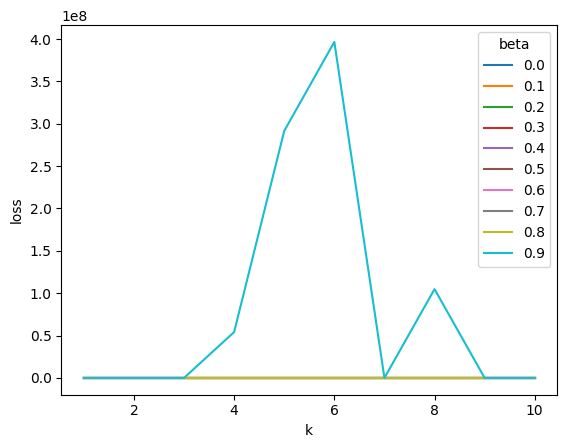

In [9]:
sns.lineplot(data=select_cs_results, x="k", y="loss", hue="beta", palette="tab10")

In [10]:
k_opt, beta_opt, _ = select_cs_results.sort_values(by="loss").iloc[0]
k_opt = int(k_opt)
beta_opt = float(beta_opt)

In [11]:
print(f"Optimal latent dim: {k_opt}")
print(f"Optimal beta: {beta_opt}")

Optimal latent dim: 1
Optimal beta: 0.7


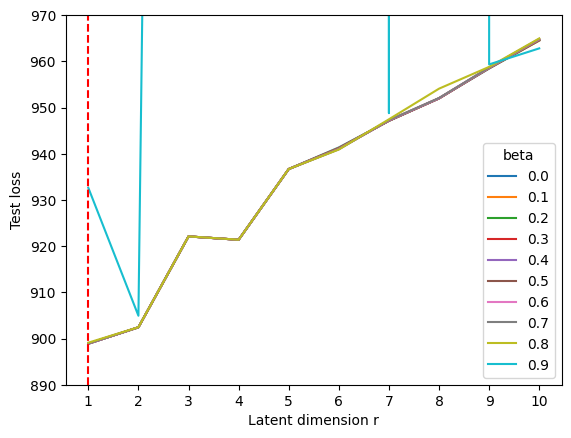

In [21]:
fig, ax = plt.subplots()
latent_dim_search_counts = sns.lineplot(
    data=select_cs_results, x="k", y="loss", hue="beta", palette="tab10"
)
plt.ylabel("Test loss")
plt.xlabel("Latent dimension r")
plt.ylim([890, 970])
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.axvline(x=k_opt, color="red", linestyle="dashed")

plt.savefig(f"{figure_path}/select_r_beta_cs.svg")
plt.show()

In [22]:
print(f"Optimal latent dim: {k_opt}")
print(f"Optimal beta: {beta_opt}")

Optimal latent dim: 1
Optimal beta: 0.7


In [23]:
data.uns["BacSC_params_NMD"] = {"k_opt": k_opt, "beta_opt": beta_opt}

## Fit NMD with found parameters

In [24]:
n, p = data.X.shape

In [25]:
X_nmd = ut.convert_to_dense(data, layer=layer)
X_nmd = X_nmd.astype(float)
W0, H0 = cs.nuclear_norm_init(X_nmd, n, p, k_opt)
Theta0 = W0 @ H0

In [26]:
init_strat = InitializationStrategy.KNOWN_MATRIX
kernel_strat = KernelStrategy.MOMENTUM_3_BLOCK_MODEL_FREE

In [27]:
kernel_params = kernelInputTypes.Momentum3BlockAdditionalParameters(
    momentum_beta=beta_opt,
    candidate_factor_W0=W0,
    candidate_factor_H0=H0,
)
nmd_result = nmd.decompose(
    X_nmd,
    k_opt,
    kernel_strategy=kernel_strat,
    initialization=init_strat,
    kernel_params=kernel_params,
    manual_max_iterations=200,
    verbose=True,
    tolerance=None,
)

INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None
INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.428400668781251e-05 loop took 31.317214823997347 overall (0.15658607411998673/ea)


In [28]:
data.obsm["X_nmd"] = nmd_result.factors[0]
data.varm["nmd_components"] = nmd_result.factors[1].T
data.layers["Theta_nmd"] = nmd_result.factors[0] @ nmd_result.factors[1]

## Investigate NMD embeddings, "components" and reconstruction

#### Reconstruction

Plot reconstruction of the data before and after fitting NMD.

In [29]:
df_reconstruction_nuclearinit_nmd = pd.DataFrame.from_dict(
    {
        layer: ut.convert_to_dense_counts(data, layer=layer).flatten(),
        "nuclear_init": np.round(np.maximum(0, W0 @ H0)).flatten(),
        "3B-NMD": np.round(
            np.maximum(0, data.obsm["X_nmd"] @ data.varm["nmd_components"].T)
        ).flatten(),
    }
)

max_val = max(
    np.max(df_reconstruction_nuclearinit_nmd[layer]),
    np.max(df_reconstruction_nuclearinit_nmd["nuclear_init"]),
    np.max(df_reconstruction_nuclearinit_nmd["3B-NMD"]),
)

corr_orig_nuclear = np.corrcoef(
    df_reconstruction_nuclearinit_nmd[layer],
    df_reconstruction_nuclearinit_nmd["nuclear_init"],
)[0][1]
corr_orig_3bnmd = np.corrcoef(
    df_reconstruction_nuclearinit_nmd[layer],
    df_reconstruction_nuclearinit_nmd["3B-NMD"],
)[0][1]

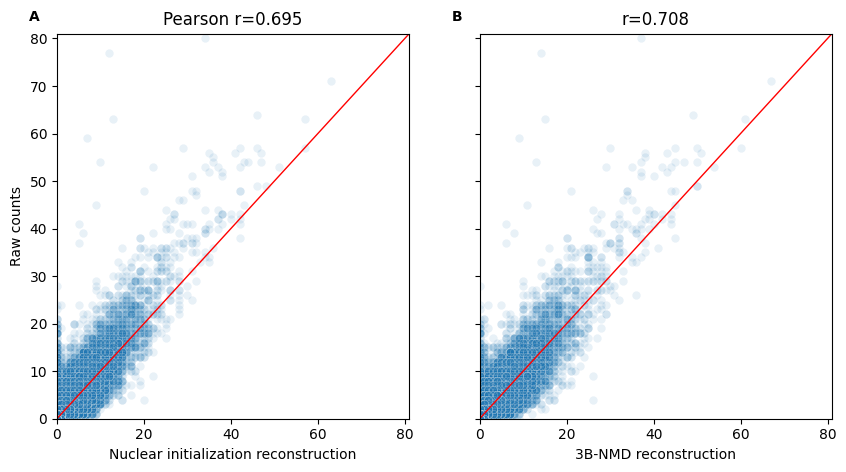

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

sns.scatterplot(
    data=df_reconstruction_nuclearinit_nmd, y=layer, x="nuclear_init", alpha=0.1, ax=ax1
)
ax1.set_title(f"Pearson r={corr_orig_nuclear:.3f}")
ax1.axline(xy1=(0, 0), slope=1, linewidth=1, color="r")
ax1.set_ylim((0, max_val + 1))
ax1.set_xlim((0, max_val + 1))
ax1.set_ylabel("Raw counts")
ax1.set_xlabel("Nuclear initialization reconstruction")
trans = mtransforms.ScaledTranslation(-20 / 72, 7 / 72, fig.dpi_scale_trans)
ax1.text(
    0.0,
    1.0,
    "A",
    transform=ax1.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)

sns.scatterplot(
    data=df_reconstruction_nuclearinit_nmd, y=layer, x="3B-NMD", alpha=0.1, ax=ax2
)
ax2.set_title(f"r={corr_orig_3bnmd:.3f}")
ax2.axline(xy1=(0, 0), slope=1, linewidth=1, color="r")
# ax2.set_ylim((0, max_val))
# ax2.set_xlim((0, max_val))
ax2.set_ylabel(None)
ax2.set_xlabel("3B-NMD reconstruction")
trans = mtransforms.ScaledTranslation(-20 / 72, 7 / 72, fig.dpi_scale_trans)
ax2.text(
    0.0,
    1.0,
    "B",
    transform=ax2.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)

# plt.savefig(f"{figure_path}/reconstruction_nuclear_init_vs_3bnmd.svg", format="svg")
plt.savefig(
    f"{figure_path}/reconstruction_nuclear_init_vs_3bnmd.png", format="png", dpi=300
)
plt.show()

#### NMD embeddings: before and after fitting

Comparison of NMD embeddings before (results of nuclear initialization) and after fitting NMD

In [33]:
W0_length = len(W0.flatten())
dict_histogram_W0nuclear_vs_W_nmd = {
    "dim_1": np.concatenate((W0, data.obsm["X_nmd"])).flatten(),
    "W0_W_nmd": ["W0 (nuclear init.)"] * W0_length + ["W (3B-NMD)"] * W0_length,
}
df_histogram_W0nuclear_vs_W_nmd_r1 = pd.DataFrame.from_dict(
    dict_histogram_W0nuclear_vs_W_nmd
)

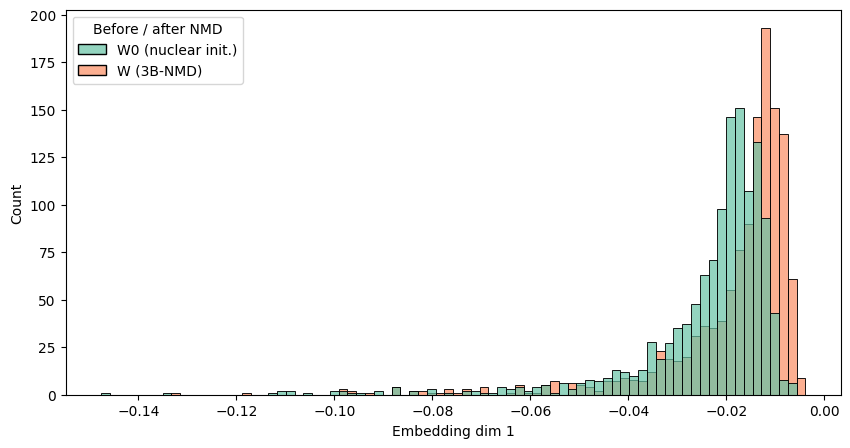

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
histogram_W0_dim1_nuclear_vs_W_nmd_r1 = sns.histplot(
    data=df_histogram_W0nuclear_vs_W_nmd_r1,
    x="dim_1",
    hue="W0_W_nmd",
    bins=80,
    alpha=0.7,
    palette="Set2",
)
histogram_W0_dim1_nuclear_vs_W_nmd_r1.legend_.set_title("Before / after NMD")
ax.set_xlabel("Embedding dim 1")

plt.savefig(f"{figure_path}/histogram_W0_dim1_nuclear_vs_W_nmd.svg", format="svg")
plt.show()

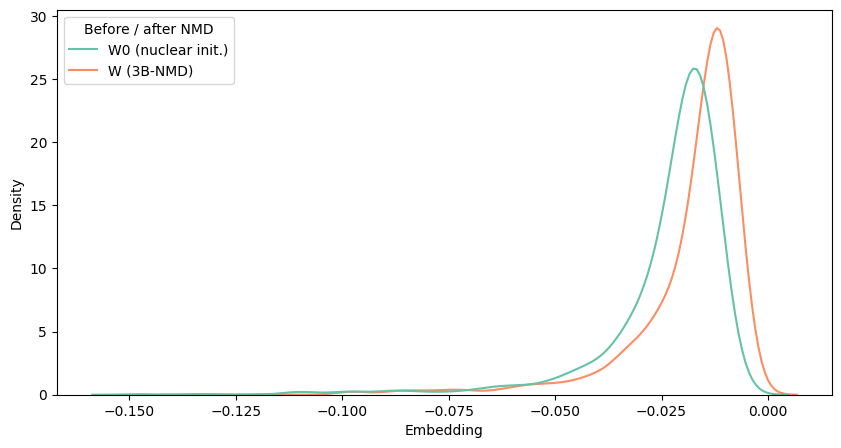

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))
kdeplot_W0_dim1_nuclear_vs_W_nmd_r1 = sns.kdeplot(
    data=df_histogram_W0nuclear_vs_W_nmd_r1, x="dim_1", hue="W0_W_nmd", palette="Set2"
)
kdeplot_W0_dim1_nuclear_vs_W_nmd_r1.legend_.set_title("Before / after NMD")
ax.set_xlabel("Embedding")

plt.savefig(f"{figure_path}/kdeplot_W0_dim1_nuclear_vs_W_nmd.svg", format="svg")
plt.show()

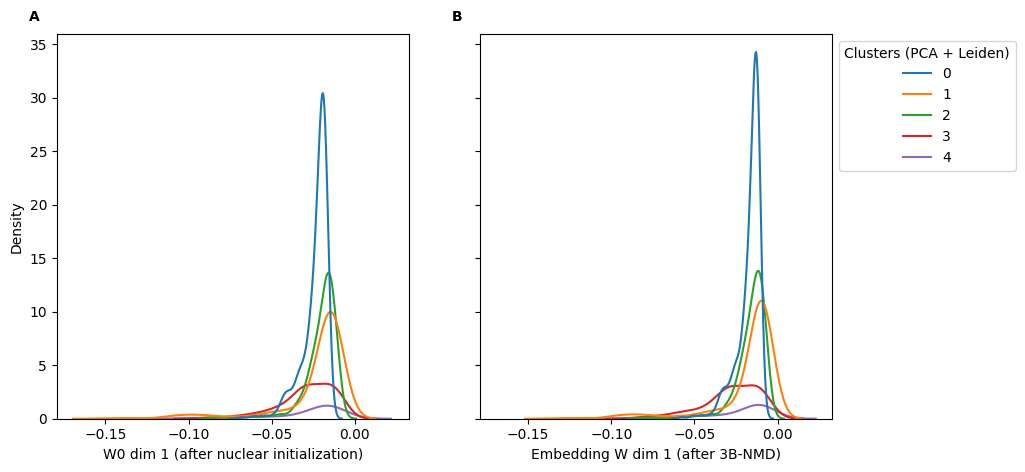

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=[10, 5])
sns.kdeplot(
    x=W0[:, 0:1].flatten(), hue=data.obs["leiden_opt_PCA"], ax=ax1, legend=False
)
ax1.set_xlabel("W0 dim 1 (after nuclear initialization)")
trans = mtransforms.ScaledTranslation(-20 / 72, 7 / 72, fig.dpi_scale_trans)
ax1.text(
    0.0,
    1.0,
    "A",
    transform=ax1.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)

sns.kdeplot(
    x=data.obsm["X_nmd"][:, 0:1].flatten(), hue=data.obs["leiden_opt_PCA"], ax=ax2
).axes.legend_.set_title("Clusters (PCA + Leiden)")
ax2.set_xlabel("Embedding W dim 1 (after 3B-NMD)")
ax2.text(
    0.0,
    1.0,
    "B",
    transform=ax2.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))


plt.savefig(
    f"{figure_path}/kde_W0_dim1_nuclear_vs_W_nmd_by_pca_cluster.svg", format="svg"
)
plt.show()

#### NMD embeddings vs. sequencing depth

Embeddings dimensions (separately) vs. sequencing depth.

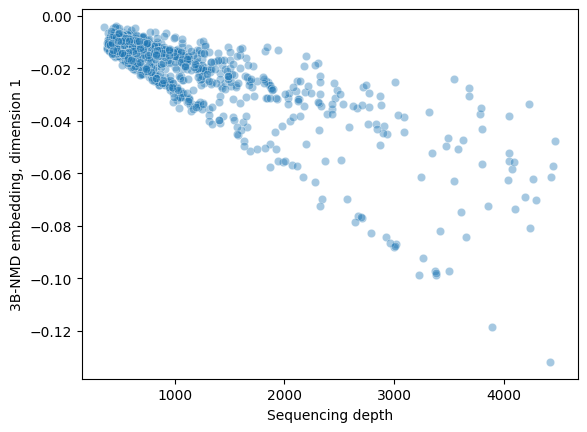

In [38]:
scatter_seqdepth_nmd_dim1 = sns.scatterplot(
    y=data.obsm["X_nmd"][:, 0:1].flatten(), x=data.obs["total_counts"], alpha=0.4
)
plt.ylabel("3B-NMD embedding, dimension 1")
plt.xlabel("Sequencing depth")


plt.savefig(f"{figure_path}/scatter_seqdepth_nmd_dim1.svg", format="svg")
plt.show()

In [40]:
corr_dim1_seqdepth = np.corrcoef(
    data.obsm["X_nmd"].flatten(), data.obs["total_counts"]
)[0][1]

print(
    f"Correlation between embedding dim 1 and sequencing depth: {corr_dim1_seqdepth:.3f}"
)

Correlation between embedding dim 1 and sequencing depth: -0.827


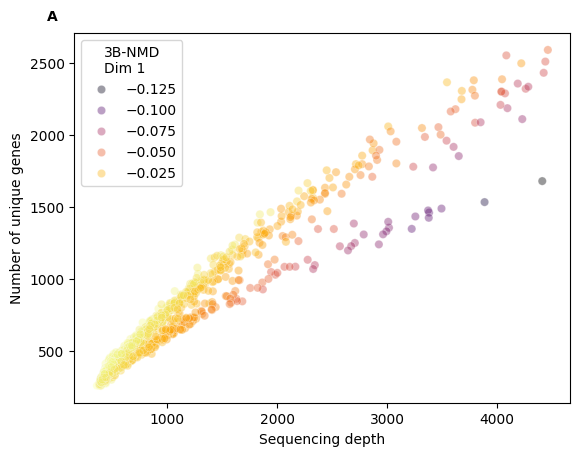

In [42]:
fig, ax = plt.subplots()
sns.scatterplot(
    x=data.obs["total_counts"],
    y=data.obs["n_genes_by_counts"],
    hue=data.obsm["X_nmd"].flatten(),
    alpha=0.4,
    palette="inferno",
    ax=ax,
)
ax.set_ylabel("Number of unique genes")
ax.set_xlabel("Sequencing depth")
ax.legend_.set_title("3B-NMD\nDim 1")
trans = mtransforms.ScaledTranslation(-20 / 72, 7 / 72, fig.dpi_scale_trans)
ax.text(
    0.0,
    1.0,
    "A",
    transform=ax.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)
plt.savefig(f"{figure_path}/sequencingdepth_uniquegenes_hueNMD.svg", format="svg")
plt.show()

#### NMD "components" vs. mean counts

NMD "components" are `p x k`, where `p` is the number of columns in the original data and `k` is the number of NMD latent dimensions.

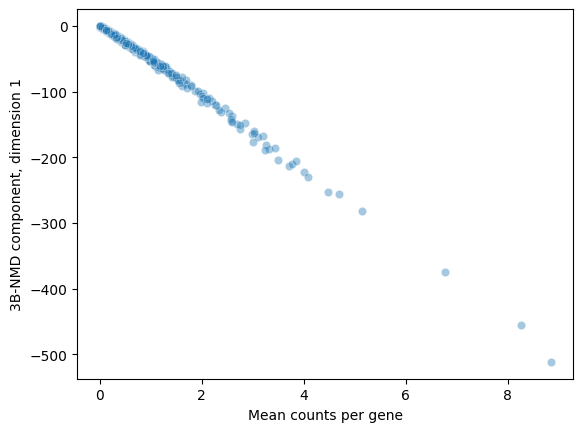

In [43]:
scatter_seqdepth_nmd_dim1 = sns.scatterplot(
    y=data.varm["nmd_components"][:, 0:1].flatten(),
    x=data.var["mean_counts"],
    alpha=0.4,
)
plt.ylabel("3B-NMD component, dimension 1")
plt.xlabel("Mean counts per gene")


plt.savefig(f"{figure_path}/scatter_mean_counts_nmd_comp1.svg", format="svg")
plt.show()

In [44]:
corr_comp2_meancountspergene = np.corrcoef(
    data.varm["nmd_components"][:, 0:1].flatten(), data.var["mean_counts"]
)[0][1]

print(
    f"Correlation between embedding component 1 and mean counts per gene: {corr_comp2_meancountspergene:.3f}"
)

Correlation between embedding component 1 and mean counts per gene: -0.998


#### NMD embeddings vs. PCs

Colored by clustering found using PCA + Leiden

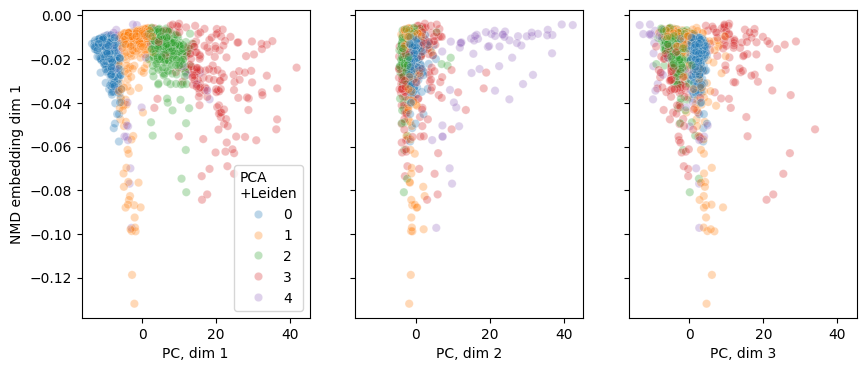

In [45]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[10, 4], sharex=True, sharey=True)
sns.scatterplot(
    y=data.obsm["X_nmd"].flatten(),
    x=data.obsm["X_pca"][:, 0:1].flatten(),
    alpha=0.3,
    hue=data.obs["leiden_opt_PCA"],
    ax=ax1,
)
ax1.set_xlabel("PC, dim 1")
ax1.set_ylabel("NMD embedding dim 1")
ax1.legend_.set_title("PCA\n+Leiden")

sns.scatterplot(
    y=data.obsm["X_nmd"].flatten(),
    x=data.obsm["X_pca"][:, 1:2].flatten(),
    alpha=0.3,
    hue=data.obs["leiden_opt_PCA"],
    ax=ax2,
)
ax2.set_xlabel("PC, dim 2")
ax2.legend_.set_visible(None)

sns.scatterplot(
    y=data.obsm["X_nmd"].flatten(),
    x=data.obsm["X_pca"][:, 2:3].flatten(),
    alpha=0.3,
    hue=data.obs["leiden_opt_PCA"],
    ax=ax3,
)
ax3.set_xlabel("PC, dim 3")
ax3.legend_.set_visible(None)

plt.show()

## Clustering

Fit NMD on train and test data

In [17]:
X_train = ut.convert_to_dense(data_train, layer="counts")
X_train = X_train.astype(float)
m, n = X_train.shape
W0_train, H0_train = cs.nuclear_norm_init(X_train, m, n, int(k_opt))

X_test = ut.convert_to_dense(data_test, layer="counts")
X_test = X_test.astype(float)
W0_test, H0_test = cs.nuclear_norm_init(X_test, m, n, int(k_opt))

In [18]:
init_strat = InitializationStrategy.KNOWN_MATRIX
kernel_strat = KernelStrategy.MOMENTUM_3_BLOCK_MODEL_FREE

kernel_params_train = kernelInputTypes.Momentum3BlockAdditionalParameters(
    momentum_beta=beta_opt,
    candidate_factor_W0=W0_train,
    candidate_factor_H0=H0_train,
)

kernel_params_test = kernelInputTypes.Momentum3BlockAdditionalParameters(
    momentum_beta=beta_opt,
    candidate_factor_W0=W0_test,
    candidate_factor_H0=H0_test,
)

In [19]:
nmd_result_train = nmd.decompose(
    X_train,
    int(k_opt),
    kernel_strategy=kernel_strat,
    initialization=init_strat,
    kernel_params=kernel_params_train,
    manual_max_iterations=200,
    verbose=True,
    tolerance=None,
)

INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None
INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.563200152711943e-05 loop took 53.822844570997404 overall (0.26911422285498704/ea)


In [20]:
nmd_result_test = nmd.decompose(
    X_test,
    int(k_opt),
    kernel_strategy=kernel_strat,
    initialization=init_strat,
    kernel_params=kernel_params_test,
    manual_max_iterations=200,
    verbose=True,
    tolerance=None,
)

INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None
INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.5607001336757094e-05 loop took 48.386906166997505 overall (0.24193453083498753/ea)


In [21]:
data_train.obsm["X_nmd"] = nmd_result_train.factors[0]
data_test.obsm["X_nmd"] = nmd_result_test.factors[0]

data_train.varm["nmd_components"] = nmd_result_train.factors[1].T
data_test.varm["nmd_components"] = nmd_result_test.factors[1].T

data_train.layers["Theta"] = nmd_result_train.factors[0] @ nmd_result_train.factors[1]
data_test.layers["Theta"] = nmd_result_test.factors[0] @ nmd_result_test.factors[1]

In [29]:
sc.pp.neighbors(
    data_train,
    n_neighbors=n_neighbors_opt,
    n_pcs=int(k_opt),
    use_rep="X_nmd",
    key_added="NMD",
)
sc.tl.umap(
    data_train, neighbors_key="NMD", min_dist=min_dist_opt, spread=1, random_state=1234
)

sc.pp.neighbors(
    data_test,
    n_neighbors=n_neighbors_opt,
    n_pcs=int(k_opt),
    use_rep="X_nmd",
    key_added="NMD",
)
sc.tl.umap(
    data_test, neighbors_key="NMD", min_dist=min_dist_opt, spread=1, random_state=1234
)

In [30]:
theta_opt, mirror_opt, umap_2_opt, ssd = ut.find_opt_umap_rotation(
    data_train.obsm["X_umap"].copy(), data_test.obsm["X_umap"].copy()
)
data_test.obsm["X_umap_rotated"] = umap_2_opt

In [31]:
res_min = 0.01
res_max = 0.5
res_step = 0.02
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)

In [39]:
importlib.reload(co)

<module 'tools.clustering_opt' from '/Users/stffn/projects/thesis_dev/msc_thesis/application/tools/clustering_opt.py'>

In [40]:
co.cluster_train_test(
    data_train,
    data_test,
    resolutions,
    alg="leiden",
    neighbors_key="NMD",
    random_state=786469,
)

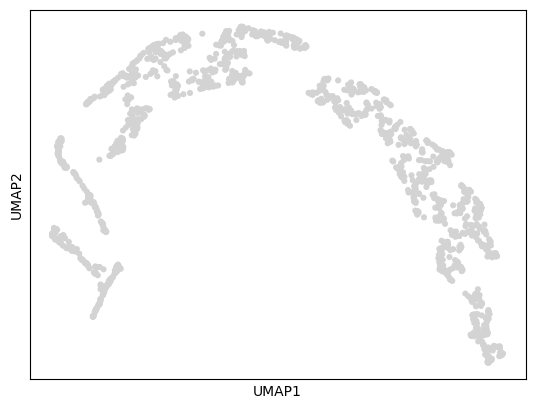

In [42]:
sc.pl.umap(data_train, neighbors_key="NMD")

In [55]:
res_opt = 0.03

In [56]:
data.uns["BacSC_params_NMD"]["res_opt"] = n_neighbors_opt

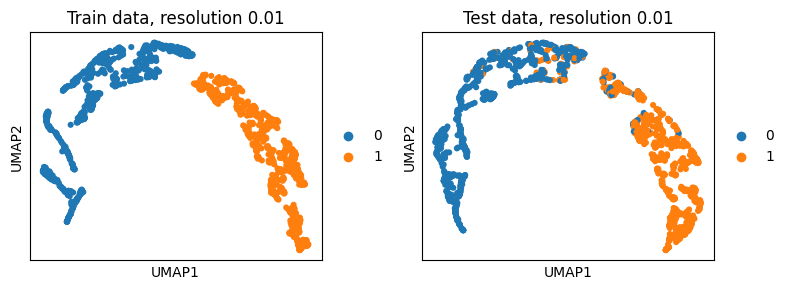

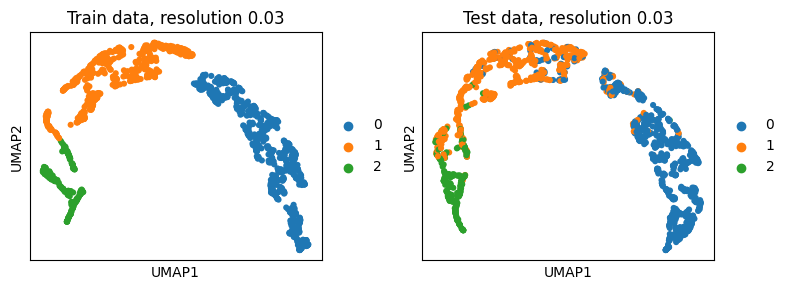

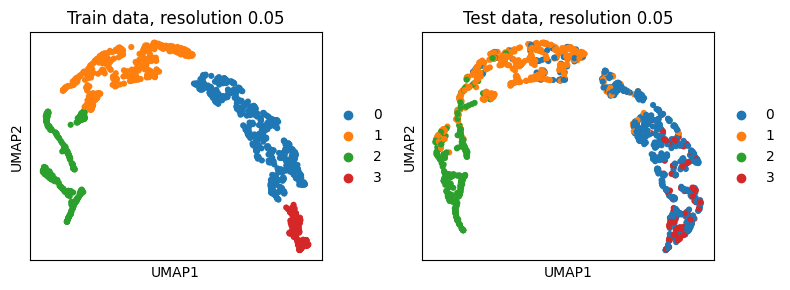

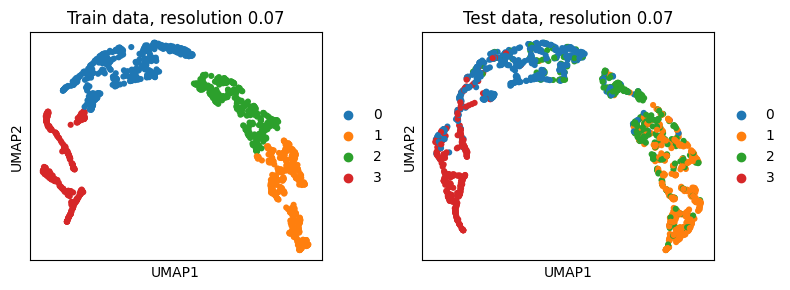

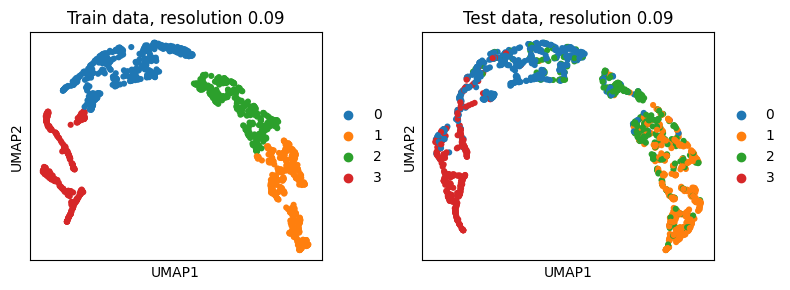

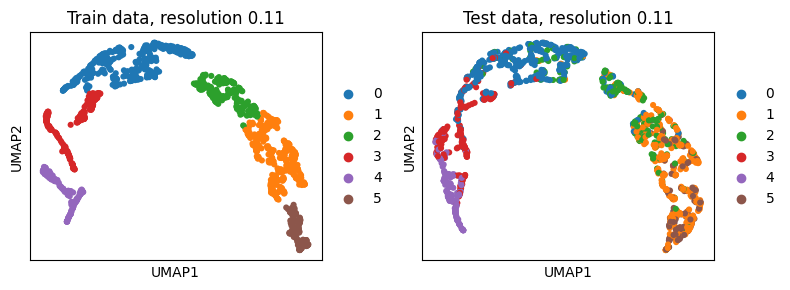

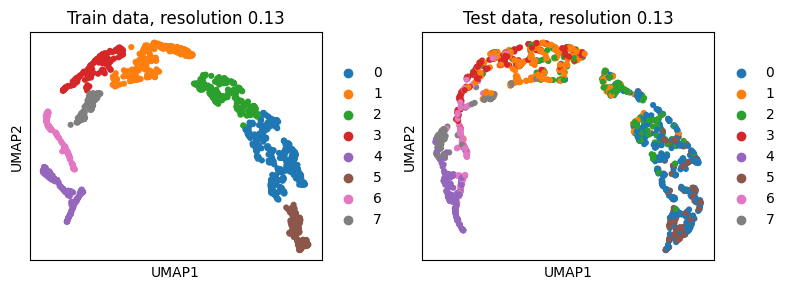

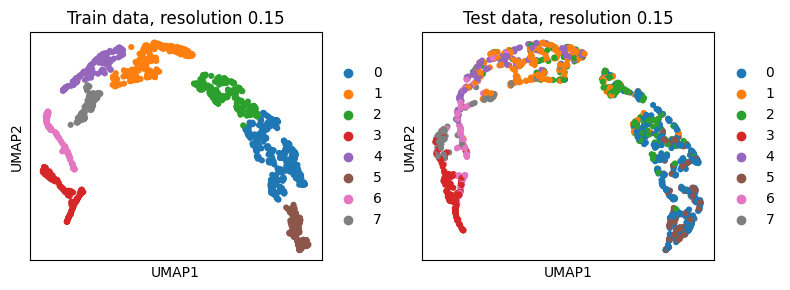

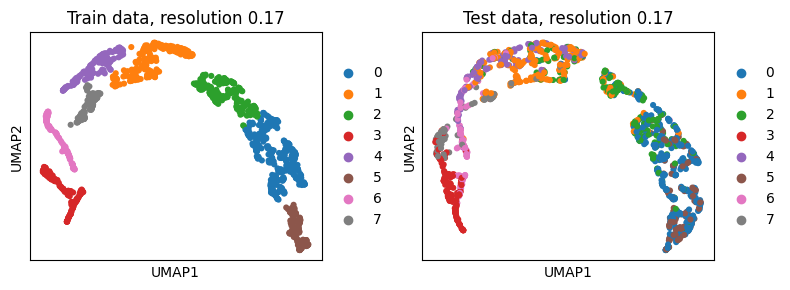

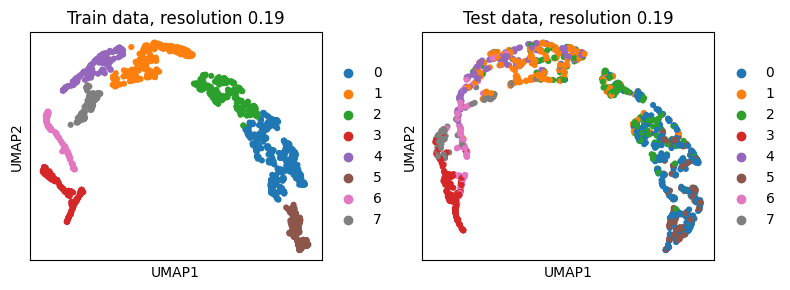

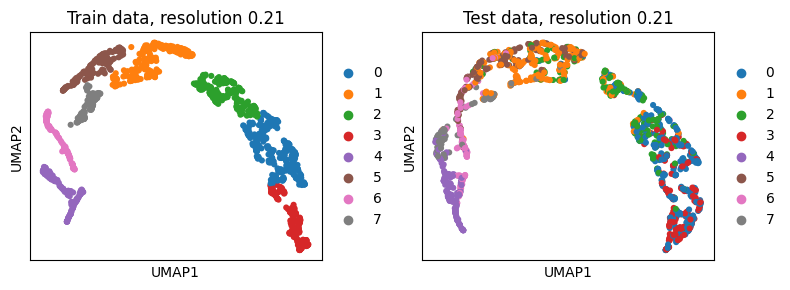

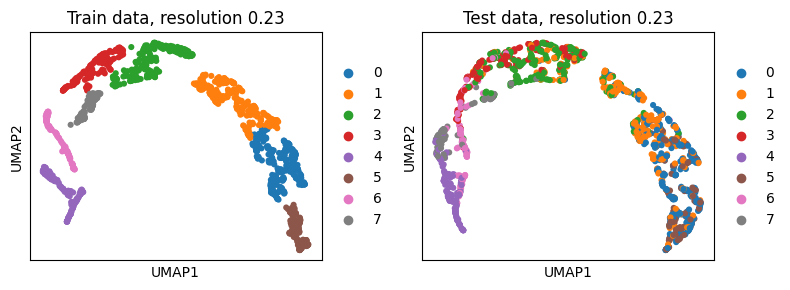

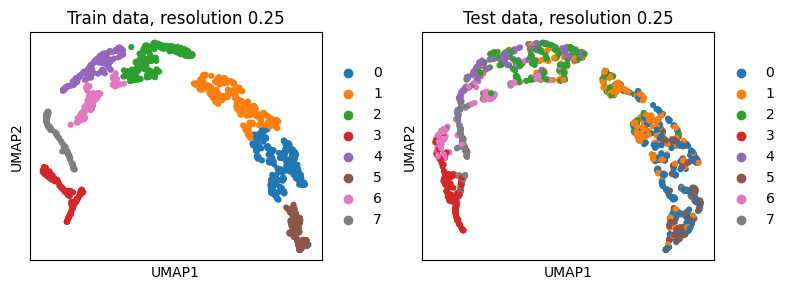

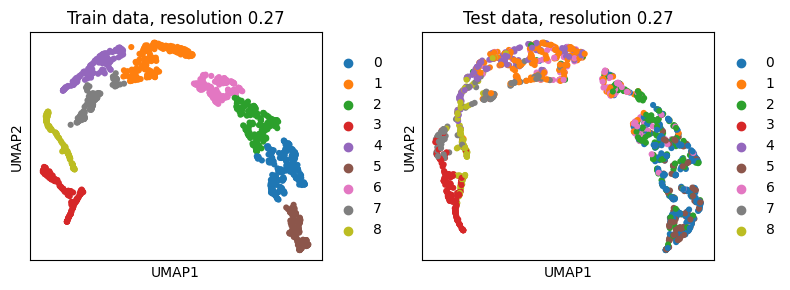

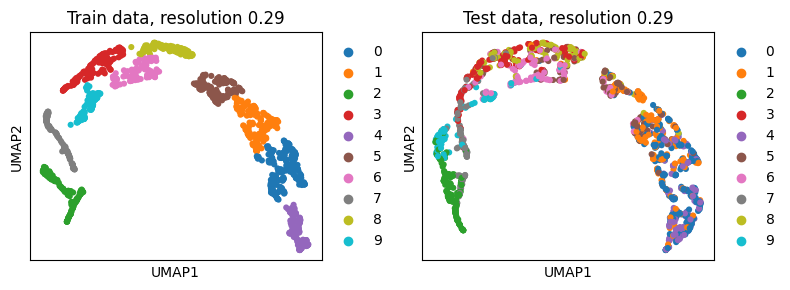

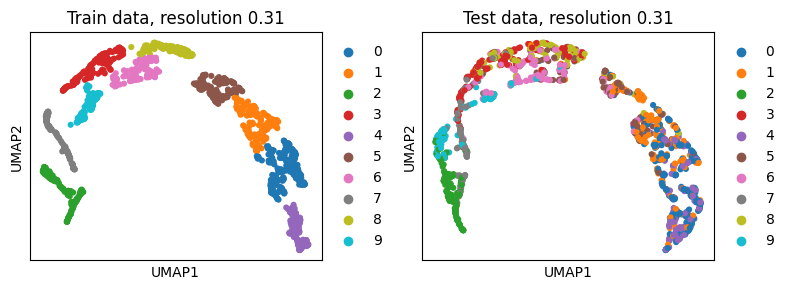

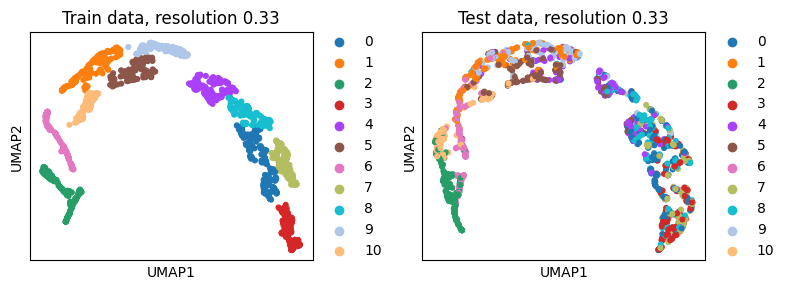

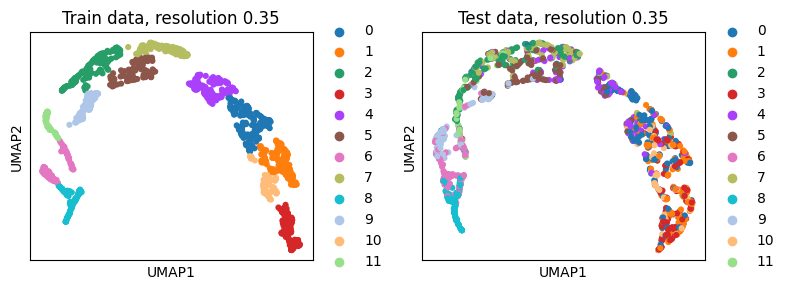

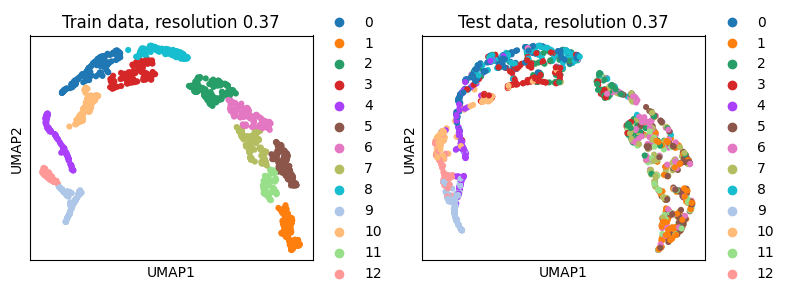

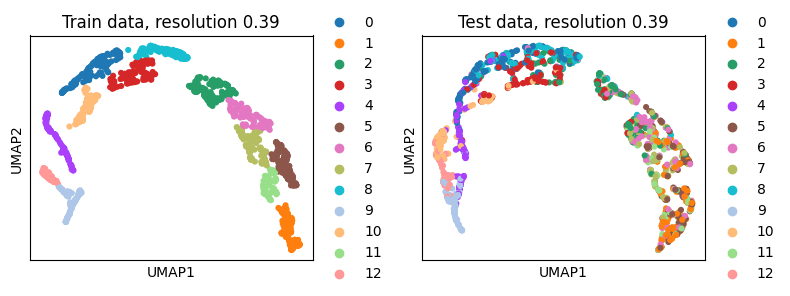

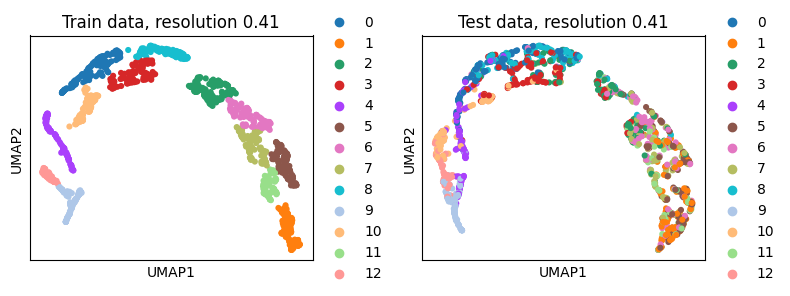

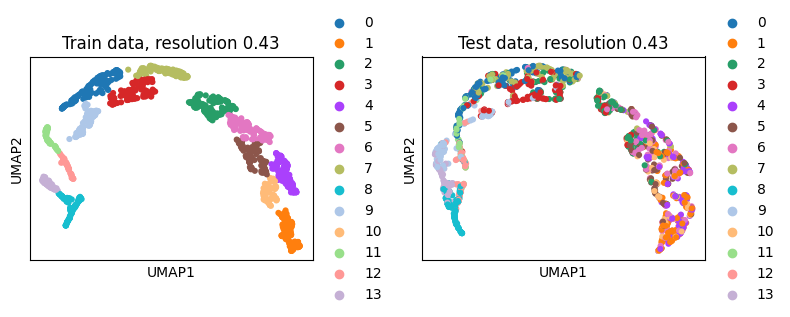

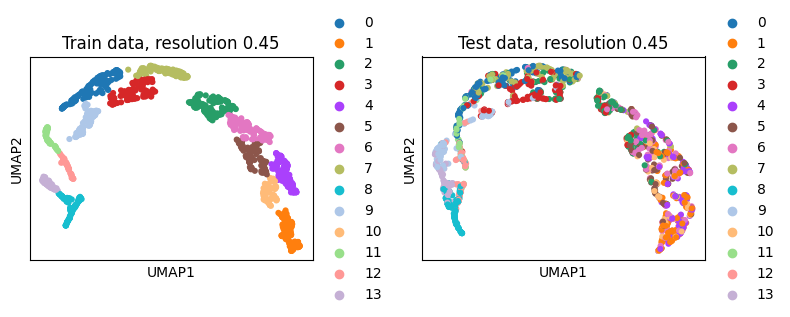

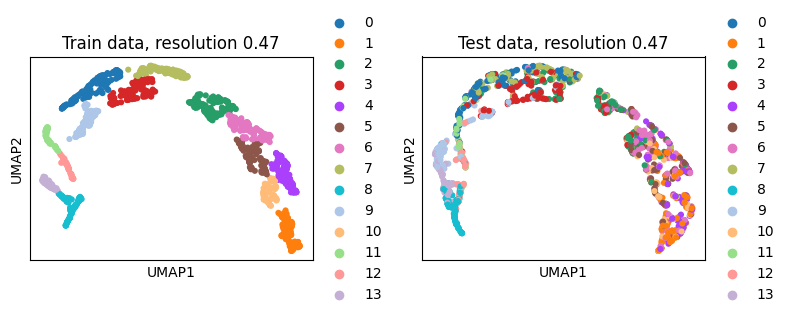

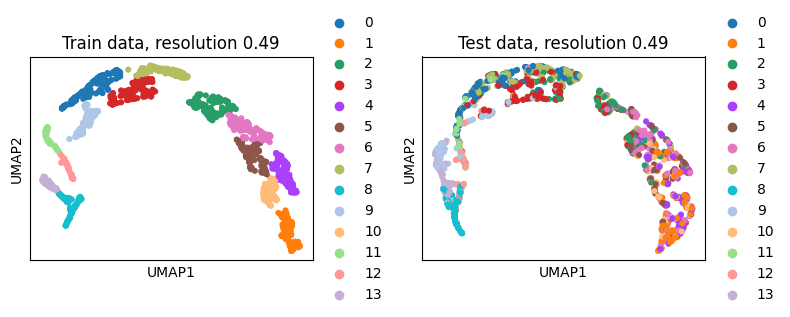

In [43]:
for resolution in resolutions:
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    sc.pl.umap(
        data_train,
        color=f"NMD_leiden_res{resolution}",
        ax=ax[0],
        title=f"Train data, resolution {resolution}",
        show=False,
        neighbors_key="NMD",
    )
    sc.pl.embedding(
        data_test,
        basis="X_umap_rotated",
        color=f"NMD_leiden_res{resolution}",
        ax=ax[1],
        title=f"Test data, resolution {resolution}",
        show=False,
        neighbors_key="NMD",
    )
    ax[1].set_xlabel("UMAP1")
    ax[1].set_ylabel("UMAP2")
    plt.tight_layout()
    plt.show()

In [45]:
importlib.reload(co)
mod_df, mod_df_wide, res_opt = co.find_optimal_clustering_resolution(
    data_train, data_test, resolutions, res_key="NMD_leiden_res", neighbors_key="NMD"
)

print(f"Optimal resolution {res_opt}")

resolution: 0.01 - clusters: 2 - Train: 0.491 - Test: 0.435 - Random: 0.248
resolution: 0.03 - clusters: 3 - Train: 0.482 - Test: 0.402 - Random: 0.186
resolution: 0.05 - clusters: 4 - Train: 0.474 - Test: 0.321 - Random: 0.133
resolution: 0.07 - clusters: 4 - Train: 0.469 - Test: 0.314 - Random: 0.11
resolution: 0.09 - clusters: 4 - Train: 0.464 - Test: 0.309 - Random: 0.1
resolution: 0.11 - clusters: 6 - Train: 0.459 - Test: 0.258 - Random: 0.074
resolution: 0.13 - clusters: 8 - Train: 0.457 - Test: 0.222 - Random: 0.052
resolution: 0.15 - clusters: 8 - Train: 0.453 - Test: 0.219 - Random: 0.051
resolution: 0.17 - clusters: 8 - Train: 0.45 - Test: 0.216 - Random: 0.048
resolution: 0.19 - clusters: 8 - Train: 0.447 - Test: 0.213 - Random: 0.045
resolution: 0.21 - clusters: 8 - Train: 0.445 - Test: 0.205 - Random: 0.04
resolution: 0.23 - clusters: 8 - Train: 0.442 - Test: 0.202 - Random: 0.037
resolution: 0.25 - clusters: 8 - Train: 0.439 - Test: 0.199 - Random: 0.036
resolution: 0.27 

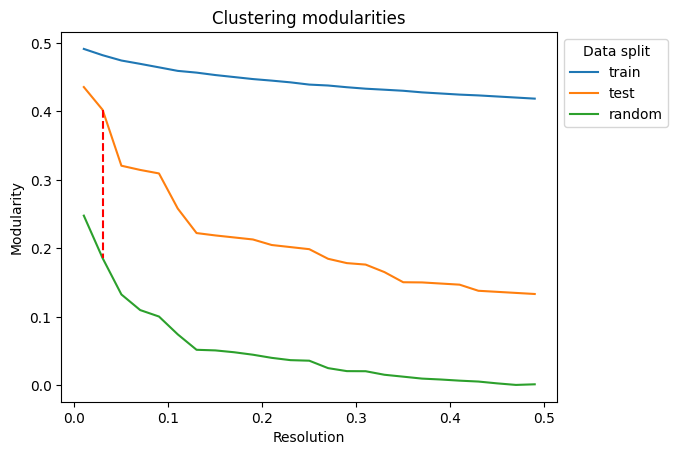

In [47]:
fig, ax = plt.subplots()
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type")
ax.set(title="Clustering modularities", xlabel="Resolution", ylabel="Modularity")

ax.plot(
    [res_opt, res_opt],
    [
        mod_df[(mod_df["resolution"] == res_opt) & (mod_df["type"] == "test")]["score"],
        mod_df[(mod_df["resolution"] == res_opt) & (mod_df["type"] == "random")][
            "score"
        ],
    ],
    linestyle="dashed",
    color="red",
)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.legend_.set_title("Data split")

plt.savefig(f"{figure_path}/modularities_plot_nmd_NMDCluster.svg", format="svg")
plt.show()

In [57]:
sc.pp.neighbors(
    data,
    n_neighbors=n_neighbors_opt,
    n_pcs=int(k_opt),
    use_rep="X_nmd",
    key_added="NMD",
)

In [58]:
sc.tl.leiden(
    data,
    resolution=res_opt,
    key_added="leiden_opt_NMD",
    neighbors_key="NMD",
)

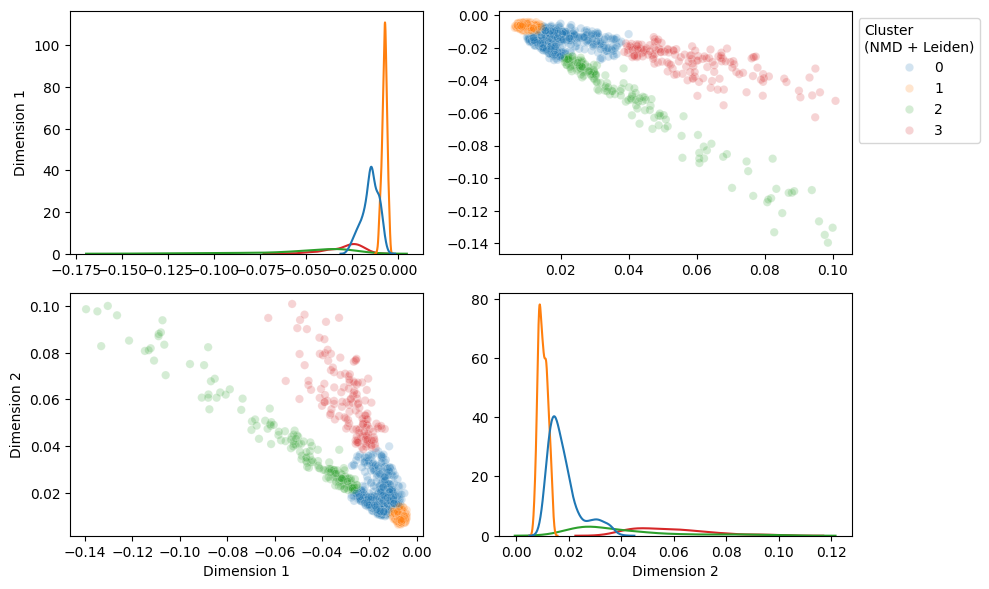

In [40]:
embeddings_2_plot = data.obsm["X_nmd"]
_, p = embeddings_2_plot.shape

fig, axs = plt.subplots(p, p, figsize=[10, 6], sharex=False)

hist_y_lim = [0, 250]
hist_bins = 20

scatter_lim = [embeddings_2_plot.min() - 0.01, embeddings_2_plot.max() + 0.01]
scatter_alpha = 0.2

scatter_hue = data.obs["leiden_opt_NMD"]


for i, row in enumerate(axs):
    for j, axis in enumerate(row):
        if i == j:
            sns.kdeplot(
                x=embeddings_2_plot[:, i : (i + 1)].flatten(),
                ax=axis,
                legend=False,
                hue=scatter_hue,
            )
        else:
            use_legend = (i == 0 and j == (p - 1)) and (scatter_hue is not None)
            sns.scatterplot(
                y=embeddings_2_plot[:, i : (i + 1)].flatten(),
                x=embeddings_2_plot[:, j : (j + 1)].flatten(),
                alpha=scatter_alpha,
                hue=scatter_hue,
                ax=axis,
                legend=use_legend,
            )
            if use_legend:
                sns.move_legend(axis, "upper left", bbox_to_anchor=(1, 1))
                axis.legend_.set_title("Cluster\n(NMD + Leiden)")
        if j == 0:
            axis.set_ylabel(f"Dimension {i + 1}")
        else:
            axis.set_ylabel(None)
        if i == len(row) - 1:
            axis.set_xlabel(f"Dimension {j + 1}")
        else:
            axis.set_xlabel(None)

plt.tight_layout()


# plt.savefig(fig_path_rank3_norm_nmd + "embedding_plot_nmd_norm_r3_hueNMDCluster_diagKDE.svg", format="svg")
plt.show()

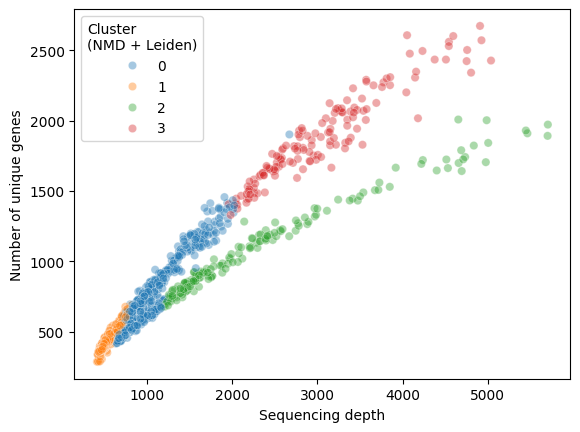

In [60]:
scatter_seqdepth_uniquegenes_hue_nmd_normr3_leidenopt = sns.scatterplot(
    x=data.obs["total_counts"],
    y=data.obs["n_genes"],
    hue=data.obs["leiden_opt_NMD"],
    alpha=0.4,
)
plt.ylabel("Number of unique genes")
plt.xlabel("Sequencing depth")
scatter_seqdepth_uniquegenes_hue_nmd_normr3_leidenopt.axes.legend_.set_title(
    "Cluster\n(NMD + Leiden)"
)

# plt.savefig(fig_path_rank3_norm_nmd + "./scatter_seqdepth_uniquegenes_hue_nmd_normr3_leidenopt.svg", format="svg")

plt.show()

In [64]:
data

AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt', 'leiden_opt_NMD'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std'
    uns: 'BacSC_params_PCA', 'PCA', 'leiden', 'leiden_opt_colors', 'pca', 'umap', 'BacSC_params_NMD', 'NMD', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap', 'X_nmd'
    varm: 'PCs', 'nmd_components'
    layers: 'counts', 'vst_counts', 'Theta_nmd'
    obsp: 'PCA_connectivities', 'PCA_distances', 'NMD_distances', 'NMD_connectivities'

In [ ]:
umap_pca_leiden_opt = sc.pl.umap(
    data, color="leiden_opt_PCA", return_fig=True, palette=sns.color_palette("tab10")
)
ax = umap_pca_leiden_opt.axes[0]
ax.legend_.set_title("Clusters\n(PCA + Leiden)")
ax.set_title(None)
# plt.savefig("./pca_umap_pca_cluster.svg")
plt.show()

## Differential expression

In [61]:
sc.tl.rank_genes_groups(data, "leiden_opt_NMD", method="wilcoxon")

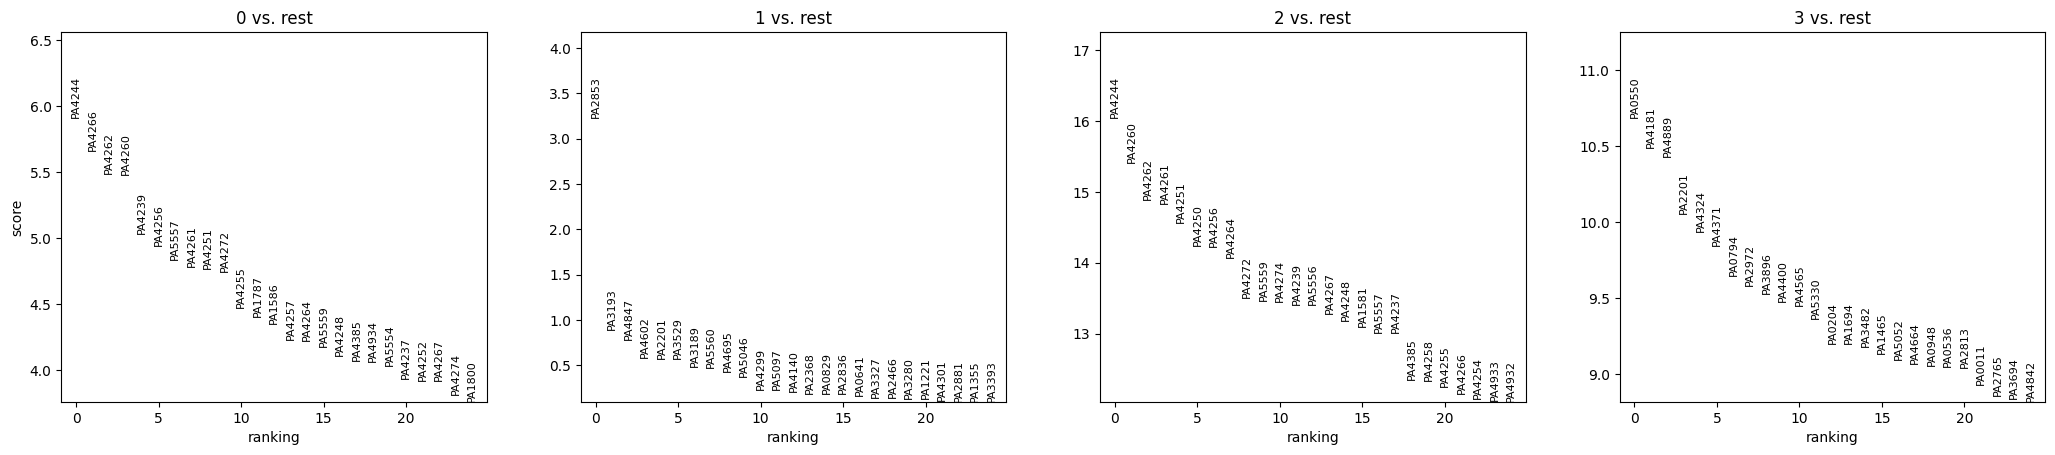

In [62]:
sc.pl.rank_genes_groups(data, n_genes=25, sharey=False)

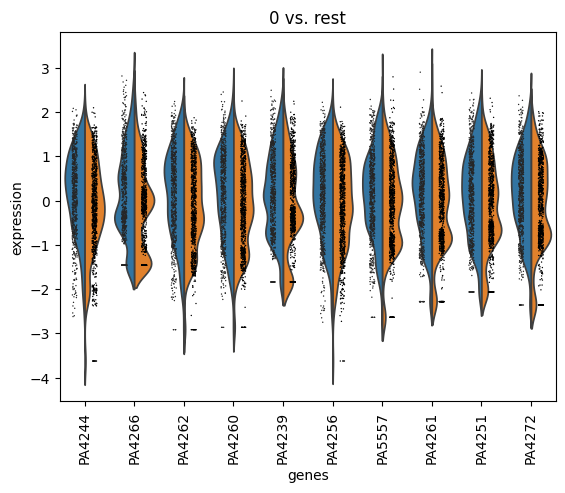

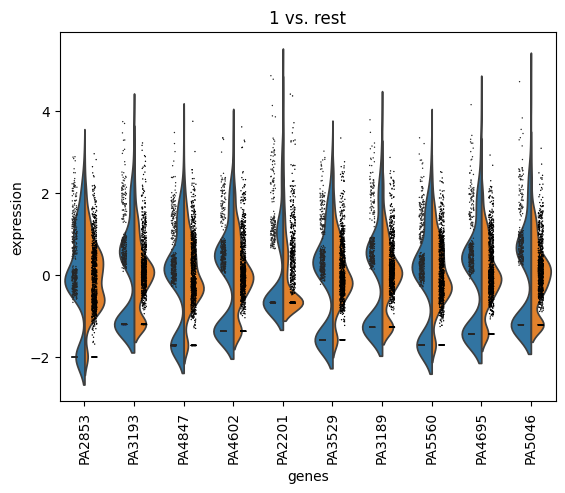

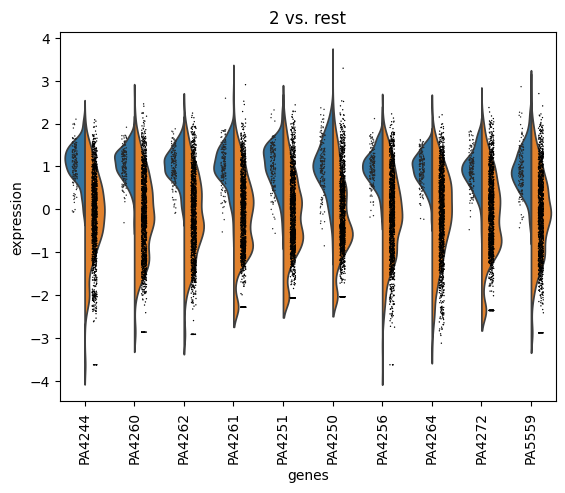

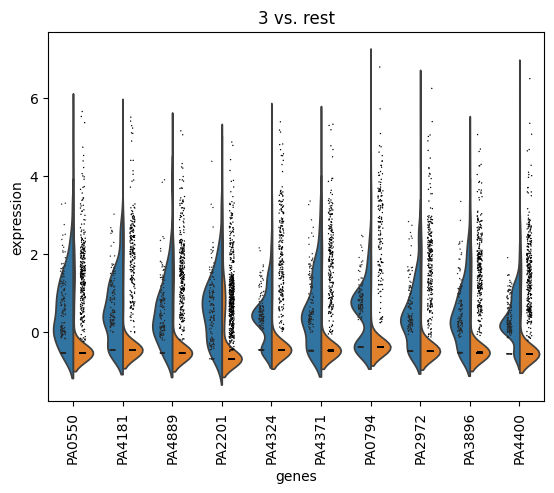

In [63]:
nclust = len(np.unique(data.obs["leiden_opt_NMD"]))

for i in range(nclust):
    sc.pl.rank_genes_groups_violin(data, groups=str(i), n_genes=10)

In [67]:
data.write(data_path + "/nmd_raw_counts.h5ad")

In [5]:
data = sc.read_h5ad(data_path + "/nmd_raw_counts.h5ad")

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '../data/S2/nmd_raw_counts.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)